In [27]:
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
import plotly.figure_factory as ff
import sympy as sp
from sympy import I, sqrt, symbols
import matplotlib.pyplot as plt

# Read In csvss
games = pd.read_csv("nfl-big-data-bowl-2023/games.csv")
plays = pd.read_csv("nfl-big-data-bowl-2023/plays.csv")
players = pd.read_csv("nfl-big-data-bowl-2023/players.csv")
week1 = pd.read_csv("nfl-big-data-bowl-2023/week1.csv")
pffScoutingData = pd.read_csv("nfl-big-data-bowl-2023/pffScoutingData.csv")

def passSucceeded(row):
    if row["passResult"] == "C":
        return 1
    else:
        return 0
plays["passSucceeded"] = plays.apply(passSucceeded, axis = 1)
print(plays["passSucceeded"])

joined_all = pd.merge(games,plays,how="inner",on = "gameId")
joined_all = pd.merge(joined_all,week1,how="inner",on=["gameId","playId"])
# left join on players to keep football records
joined_all = pd.merge(joined_all,players,how="left",on = "nflId")

itter_all = joined_all[joined_all["passResult"].isin(["C", "IN", "I"])]

0       0
1       1
2       1
3       0
4       0
       ..
8552    0
8553    1
8554    0
8555    0
8556    0
Name: passSucceeded, Length: 8557, dtype: int64


(array([2.6553e+04, 1.2289e+04, 1.4888e+04, 1.6369e+04, 1.5955e+04,
        1.4719e+04, 1.2032e+04, 8.8950e+03, 5.5090e+03, 2.5920e+03,
        1.0480e+03, 3.5300e+02, 1.0100e+02, 3.4000e+01, 1.5000e+01,
        6.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00]),
 array([ 0.   ,  0.623,  1.246,  1.869,  2.492,  3.115,  3.738,  4.361,
         4.984,  5.607,  6.23 ,  6.853,  7.476,  8.099,  8.722,  9.345,
         9.968, 10.591, 11.214, 11.837, 12.46 ]),
 <BarContainer object of 20 artists>)

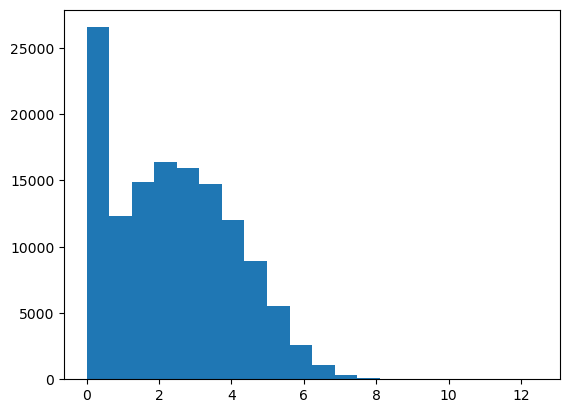

In [28]:
import matplotlib.pyplot as plt

plt.hist(joined_all[joined_all["officialPosition"].isin(["WR"])]["a"], bins = 20)

In [29]:
def dir_from_qb(row, x_QB, y_QB):
    return np.linalg.norm(np.array([x_QB, y_QB]) - np.array([row["x"], row["y"]]))

def time_to_catch(row, v_ball):
    if row["dir_from_qb"] / v_ball > 5:
        print('ERROR')
    return row["dir_from_qb"] / v_ball

def reachable_area_radius(row, a_avg):
    return 1/2 * a_avg * (row["time_to_catch"])**2

def reachable_area_cx(row):
    return row["s"] * row["time_to_catch"] * math.cos(math.radians(-row["dir"] + 90)) + row["x"]

def reachable_area_cy(row):
    return row["s"] * row["time_to_catch"] * math.sin(math.radians(-row["dir"] + 90)) + row["y"]

def circle_and_line(focused_df, selected_rows, targetFrame):
    target_team = "football"
    # footballの軌道描画
    x0 = focused_df[(focused_df.team == target_team)&(focused_df.frameId==targetFrame)]["x"].values[0]
    y0 = focused_df[(focused_df.team == target_team)&(focused_df.frameId==targetFrame)]["y"].values[0]
    x1 = focused_df[(focused_df.team == target_team)&(focused_df.frameId==targetFrame + 1)]["x"].values[0]
    y1 = focused_df[(focused_df.team == target_team)&(focused_df.frameId==targetFrame + 1)]["y"].values[0]
    
    m, b = line_calculate(x0, y0, x1, y1)
        
    selected_rows.loc[selected_rows.index, ["cross_points"]] = selected_rows.apply(circle_line_cross_x, args=(m, b), axis=1)
    
    return selected_rows
    

def circle_line_cross_x(row, m, b):
    h = row["reachable_area_cx"]
    k = row["reachable_area_cy"]
    r = row["reachable_area_radius"]
    
    x = sp.Symbol('x')
    y = sp.Symbol('y')
    
    # 方程式の定義
    equation_circle = sp.Eq((x - h)**2 + (y - k)**2, r**2)
    equation_line = sp.Eq(y, m*x + b)
    
    # 連立方程式を解く
    intersection_points = sp.solve([equation_circle, equation_line], (x, y))

    # 交点の座標を小数点に変換
    decimal_intersection_points = [(point[0].evalf(), point[1].evalf()) for point in intersection_points]
    
    return decimal_intersection_points

def line_calculate(x0, y0, x1, y1):
    m = (y0 - y1)/(x0 - x1)
    b = (x1*y0 - x0*y1)/(x1 - x0)
    return m, b

def isInRange(cp, start, end):
    return start <= cp < end

def catArea(row):
    if (row["enemy"] > 0) & (row["ally"] > 0):
        return "E&A"
    elif row["enemy"] > 0:
        return "E"
    elif row["ally"] > 0:
        return "A"
    else:
        return "F"

In [30]:
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

In [31]:
itter_id_list = plays["playId"].tolist()

for play_focus in itter_id_list:
    focused_df = itter_all[(itter_all.playId==play_focus)]
    if len(focused_df[focused_df["event"].isin(["pass_forward"])]) < 1:
        print(f"[{play_focus}]これは正確な射出データが記録されていないのでスキップします。")
        continue

    targetFrame = focused_df.loc[(focused_df["event"] == "pass_forward") & (focused_df["team"] == "football"), "frameId"].iloc[0]
    targetBeforeFrame = targetFrame - 1

    beforeRow = focused_df.loc[(focused_df["frameId"] == targetBeforeFrame) & (focused_df["team"] == "football")]
    x1 = beforeRow["x"].values[0]
    y1 = beforeRow["y"].values[0]

    targetRow = focused_df.loc[(focused_df["frameId"] == targetFrame) & (focused_df["team"] == "football")]
    x2 = targetRow["x"].values[0]
    y2 = targetRow["y"].values[0]

    # 傾きの角度を計算
    delta_x = x2 - x1
    delta_y = y2 - y1
    angle = math.atan2(delta_y, delta_x)

    # 弧度法から度数法に変換
    angle_degrees = (-math.degrees(angle) + 90) % 360

    # DataFrameの該当行に角度を設定
    focused_df.loc[(focused_df["event"] == "pass_forward") & (focused_df["team"] == "football"), "dir"] = angle_degrees

    TARGET_LIST = [
                    "dir_from_qb", "time_to_catch", "reachable_area_radius", "reachable_area_cx", "reachable_area_cy", 
                    "x0", "y0", "x1", "y1", "u", "v", "cross_points"
                  ]

    # 条件に合致する行を抽出(範囲の選択)
    selected_rows = focused_df[(focused_df["frameId"] == targetFrame) & (~focused_df["officialPosition"].isin(['QB','T', 'G', 'C', 'DE', 'DT', 'NT'])) & (~focused_df["team"].isin(['football']))]
    # selected_rows = selected_rows[~selected_rows["team"].isin(['football'])]

    # "dir_from_qb" 列に値を設定
    x_QB = focused_df[(focused_df["frameId"] == targetFrame) & (focused_df["officialPosition"] == "QB")]["x"]
    y_QB = focused_df[(focused_df["frameId"] == targetFrame) & (focused_df["officialPosition"] == "QB")]["y"]
    selected_rows.loc[selected_rows.index, "dir_from_qb"] = selected_rows.apply(dir_from_qb, args = (x_QB, y_QB), axis=1)

    # "time_to_catch" 列に値を設定
    v_ball = 20  # ボールの速度を設定してください
    selected_rows.loc[selected_rows.index, "time_to_catch"] = selected_rows.apply(time_to_catch, args=(v_ball,), axis=1)

    # "reachable_area_radius" 列に値を設定
    a_avg = 4  # WR選手の上位加速度
    selected_rows.loc[selected_rows.index, "reachable_area_radius"] = selected_rows.apply(reachable_area_radius, args=(a_avg,), axis=1)

    # "reachable_area_cx""reachable_area_cy"列に値を設定
    selected_rows.loc[selected_rows.index, "reachable_area_cx"] = selected_rows.apply(reachable_area_cx, axis=1)
    selected_rows.loc[selected_rows.index, "reachable_area_cy"] = selected_rows.apply(reachable_area_cy, axis=1)

    # "x0", "y0", "x1", "y1"列に値を設定
    selected_rows.loc[selected_rows.index, "x0"] = selected_rows["reachable_area_cx"] - selected_rows["reachable_area_radius"]
    selected_rows.loc[selected_rows.index, "y0"] = selected_rows["reachable_area_cy"] - selected_rows["reachable_area_radius"]
    selected_rows.loc[selected_rows.index, "x1"] = selected_rows["reachable_area_cx"] + selected_rows["reachable_area_radius"]
    selected_rows.loc[selected_rows.index, "y1"] = selected_rows["reachable_area_cy"] + selected_rows["reachable_area_radius"]

    # "u", "v"列に値を設定
    selected_rows.loc[selected_rows.index, "u"] = selected_rows["reachable_area_cx"] - selected_rows["x"]
    selected_rows.loc[selected_rows.index, "v"] = selected_rows["reachable_area_cy"] - selected_rows["y"]

    # 軌道と予測エリアの交点予測
    selected_rows = circle_and_line(focused_df, selected_rows, targetFrame)

    # 変更の適用
    focused_df.loc[selected_rows.index, TARGET_LIST] = selected_rows[TARGET_LIST]

    # エラーが発生しないことを確認するために、一部の行を表示
    focused_df[focused_df["frameId"] == targetFrame].head()

    focused_df['cross_x0'] = np.nan  # 新しいカラムを追加し、初期値として NaN を設定
    focused_df['cross_x1'] = np.nan  # 新しいカラムを追加し、初期値として NaN を設定
    focused_df['cross_y0'] = np.nan  # 新しいカラムを追加し、初期値として NaN を設定
    focused_df['cross_y1'] = np.nan  # 新しいカラムを追加し、初期値として NaN を設定
    focused_df['isCrossed'] = 0           # 新しいカラムを追加し、初期値として NaN を設定


    for index, data in focused_df[~focused_df["cross_points"].isna()].iterrows():
        if "I" in str(data["cross_points"][0][0]):
            continue
        focused_df.at[index, "cross_x0"] = float(data["cross_points"][0][0])
        focused_df.at[index, "cross_x1"]= float(data["cross_points"][1][0])
        focused_df.at[index, "cross_y0"] = float(data["cross_points"][0][1])
        focused_df.at[index, "cross_y1"]= float(data["cross_points"][1][1])
        focused_df.at[index, "isCrossed"]= 1


    focused_df[focused_df["isCrossed"]==1][["x", "y", "team", "cross_x0", "cross_x1"]]
    player_cross_df = focused_df[focused_df["isCrossed"]==1][["team", "cross_x0", "cross_x1"]]

    cross_point_list = focused_df[focused_df["isCrossed"]==1]["cross_x0"].unique().tolist()
    cross_point_list.extend(focused_df[focused_df["isCrossed"]==1]["cross_x1"].unique().tolist())
    cross_point_list.sort()

    area_df = pd.DataFrame(
        {
            "start_point" : cross_point_list[:-1],
            "end_point" : cross_point_list[1:],
            "check_point" : [(x + y) / 2 for x, y in zip(cross_point_list[:-1], cross_point_list[1:])],
            "enemy" : 0,
            "ally" : 0,
        }
    )
    area_df["length"] = abs(area_df["end_point"] - area_df["start_point"])

    #  'possessionTeam', 'defensiveTeam'
    possessionTeam = focused_df.possessionTeam.tolist()[0]
    defensiveTeam = focused_df.defensiveTeam.tolist()[0]

    for index, data in area_df.iterrows():
        cp = data["check_point"]
        for index_player, data_player in player_cross_df.iterrows():
            cross_range = sorted([data_player["cross_x0"], data_player["cross_x1"]])
            isInRange = cross_range[0] <= cp < cross_range[1]
            isEnemy = data_player["team"] == defensiveTeam
            isAlly = data_player["team"] == possessionTeam
            if not isInRange:
                continue
            if isEnemy:
                area_df.at[index, "enemy"] += 1
            else:
                area_df.at[index, "ally"] += 1

    area_df["category"] = area_df.apply(catArea, axis=1)

    area_dic = {
        "E" : 0,
        "A": 0,
        "E&A" : 0,
        "F" : 0
    }

    for idx, data in area_df.iterrows():
        area_dic[data["category"]] += data["length"]

    pass_result = plays.loc[plays["playId"] == play_focus, "passSucceeded"].values[0]
    
    # 分母がゼロの場合に備えて条件分岐
    denominator = area_dic["E&A"] + area_dic["E"] + area_dic["A"]
    succeed_pred = area_dic["A"] / denominator if denominator != 0 else 0


    print(f"[{play_focus}]パス成功確率：{succeed_pred}, パス結果:{pass_result}")


[97]パス成功確率：0.11404951571705962, パス結果:0
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
[137]パス成功確率：0.07577341142005545, パス結果:1
[187]パス成功確率：0.05586938793019262, パス結果:1
[282]パス成功確率：0.4859923086254011, パス結果:0
[349]パス成功確率：0.21596391404770268, パス結果:0
[410]パス成功確率：0.0, パス結果:1
[434]パス成功確率：0, パス結果:0
[456]パス成功確率：0.00563445750437896, パス結果:1
[480]パス成功確率：0, パス結果:1
[509]パス成功確率：0.0, パス結果:1
[559]パス成功確率：0.00753442151832075, パス結果:1
[583]パス成功確率：0.13821186589225573, パス結果:1
[687]パス成功確率：0.0, パス結果:1
[735]パス成功確率：0.27857006966669534, パス結果:1
[764]パス成功確率：0.8110435160698178, パス結果:1
[788]パス成功確率：1.0, パス結果:1
[869]パス成功確率：0.162034056901649, パス結果:1
[925]これは正確な射出データが記録されていないのでスキップします。
[947]パス成功確率：0.0, パス結果:0
[1078]パス成功確率：0.0, パス結果:1
[1203]パス成功確率：0.07995894018032253, パス結果:1
[1227]パス成功確率：0.34100069766235935, パス結果:1
[1267]パス成功確率：0.23731609432429668, パス結果:1
[1312]パス成功確率：0.0, パス結果:1


ValueError: operands could not be broadcast together with shapes (2,3) (2,) 

In [ ]:
itter_id_list = itter_all["playId"].tolist()

play_focus = 137
    
focused_df = itter_all[(itter_all.playId==play_focus)]

print(focused_df["event"].unique())

targetFrame = focused_df.loc[(focused_df["event"].isin(['pass_forward'])) & (focused_df["team"] == "football"), "frameId"].iloc[0]
print(targetFrame)
targetBeforeFrame = targetFrame - 1

beforeRow = focused_df.loc[(focused_df["frameId"] == targetBeforeFrame) & (focused_df["team"] == "football")]
x1 = beforeRow["x"].values[0]
y1 = beforeRow["y"].values[0]

targetRow = focused_df.loc[(focused_df["frameId"] == targetFrame) & (focused_df["team"] == "football")]
x2 = targetRow["x"].values[0]
y2 = targetRow["y"].values[0]

print("実行前角度:", targetRow["dir"].values[0])

# 傾きの角度を計算
delta_x = x2 - x1
delta_y = y2 - y1
angle = math.atan2(delta_y, delta_x)

# 弧度法から度数法に変換
angle_degrees = (-math.degrees(angle) + 90) % 360

print("傾きの角度（度数法）:", angle_degrees)

# DataFrameの該当行に角度を設定
focused_df.loc[(focused_df["event"].isin(['pass_forward'])) & (focused_df["team"] == "football"), "dir"] = angle_degrees

TARGET_LIST = [
                "dir_from_qb", "time_to_catch", "reachable_area_radius", "reachable_area_cx", "reachable_area_cy", 
                "x0", "y0", "x1", "y1", "u", "v", "cross_points"
              ]

# 条件に合致する行を抽出(範囲の選択)
selected_rows = focused_df[(focused_df["frameId"] == targetFrame) & (~focused_df["officialPosition"].isin(['QB','T', 'G', 'C', 'DE', 'DT', 'NT'])) & (~focused_df["team"].isin(['football']))]
# selected_rows = selected_rows[~selected_rows["team"].isin(['football'])]

# "dir_from_qb" 列に値を設定
x_QB = focused_df[(focused_df["frameId"] == targetFrame) & (focused_df["officialPosition"] == "QB")]["x"]
y_QB = focused_df[(focused_df["frameId"] == targetFrame) & (focused_df["officialPosition"] == "QB")]["y"]
selected_rows.loc[selected_rows.index, "dir_from_qb"] = selected_rows.apply(dir_from_qb, args = (x_QB, y_QB), axis=1)

# "time_to_catch" 列に値を設定
v_ball = 20  # ボールの速度を設定してください
selected_rows.loc[selected_rows.index, "time_to_catch"] = selected_rows.apply(time_to_catch, args=(v_ball,), axis=1)

# "reachable_area_radius" 列に値を設定
a_avg = 2  # WR選手の上位加速度
selected_rows.loc[selected_rows.index, "reachable_area_radius"] = selected_rows.apply(reachable_area_radius, args=(a_avg,), axis=1)

# "reachable_area_cx""reachable_area_cy"列に値を設定
selected_rows.loc[selected_rows.index, "reachable_area_cx"] = selected_rows.apply(reachable_area_cx, axis=1)
selected_rows.loc[selected_rows.index, "reachable_area_cy"] = selected_rows.apply(reachable_area_cy, axis=1)

# "x0", "y0", "x1", "y1"列に値を設定
selected_rows.loc[selected_rows.index, "x0"] = selected_rows["reachable_area_cx"] - selected_rows["reachable_area_radius"]
selected_rows.loc[selected_rows.index, "y0"] = selected_rows["reachable_area_cy"] - selected_rows["reachable_area_radius"]
selected_rows.loc[selected_rows.index, "x1"] = selected_rows["reachable_area_cx"] + selected_rows["reachable_area_radius"]
selected_rows.loc[selected_rows.index, "y1"] = selected_rows["reachable_area_cy"] + selected_rows["reachable_area_radius"]

# "u", "v"列に値を設定
selected_rows.loc[selected_rows.index, "u"] = selected_rows["reachable_area_cx"] - selected_rows["x"]
selected_rows.loc[selected_rows.index, "v"] = selected_rows["reachable_area_cy"] - selected_rows["y"]

# 軌道と予測エリアの交点予測
selected_rows = circle_and_line(focused_df, selected_rows, targetFrame)

# 変更の適用
focused_df.loc[selected_rows.index, TARGET_LIST] = selected_rows[TARGET_LIST]

# エラーが発生しないことを確認するために、一部の行を表示
focused_df[focused_df["frameId"] == targetFrame].head()

focused_df['cross_x0'] = np.nan  # 新しいカラムを追加し、初期値として NaN を設定
focused_df['cross_x1'] = np.nan  # 新しいカラムを追加し、初期値として NaN を設定
focused_df['cross_y0'] = np.nan  # 新しいカラムを追加し、初期値として NaN を設定
focused_df['cross_y1'] = np.nan  # 新しいカラムを追加し、初期値として NaN を設定
focused_df['isCrossed'] = 0           # 新しいカラムを追加し、初期値として NaN を設定


for index, data in focused_df[~focused_df["cross_points"].isna()].iterrows():
    if "I" in str(data["cross_points"][0][0]):
        continue
    focused_df.at[index, "cross_x0"] = float(data["cross_points"][0][0])
    focused_df.at[index, "cross_x1"]= float(data["cross_points"][1][0])
    focused_df.at[index, "cross_y0"] = float(data["cross_points"][0][1])
    focused_df.at[index, "cross_y1"]= float(data["cross_points"][1][1])
    focused_df.at[index, "isCrossed"]= 1

team_list = focused_df["team"].unique()
fig = go.Figure()

for target_team in team_list:
    target_df = focused_df[(focused_df.team == target_team)&(focused_df.frameId==targetFrame)]

    x = target_df["x"]
    x_QB = target_df[target_df['officialPosition'] == 'QB']["x"]
    x_not_QB = target_df[target_df['officialPosition'] != 'QB']["x"]
    x0 = target_df["x0"]
    x1 = target_df["x1"]

    y = target_df["y"]
    y_QB = target_df[target_df['officialPosition'] == 'QB']["y"]
    y_not_QB = target_df[target_df['officialPosition'] != 'QB']["y"]
    y0 = target_df["y0"]
    y1 = target_df["y1"]

    u = target_df["reachable_area_cx"] - target_df["x"]
    v = target_df["reachable_area_cy"] - target_df["y"]


    # 予測到達点矢印の描画
    fig_quiver = ff.create_quiver(x, y, u, v,
                           scale=1,
                           arrow_scale=0.1,
                           name='reachable center vec',
                           line_width=1,
                           line_color = colors[target_team]
                           )
    fig.add_traces(data = fig_quiver.data)

    # 選手点の描画
    fig.add_trace(go.Scatter(x=x_not_QB, y=y_not_QB, mode='markers', marker_color=colors[target_team], name=target_team))
    fig.add_trace(go.Scatter(x=x_QB, y=y_QB, mode='markers',marker_symbol='star', marker_color=colors[target_team], name=target_team))

    # 領域の描画     
    for xi, yi, xi0, yi0, xi1, yi1 in zip(x, y, x0, y0, x1, y1):
        if not np.isnan(xi0):
            fig.add_shape(type="circle",
                          xref="x", yref="y",
                          x0=xi0, y0=yi0,
                          x1=xi1, y1=yi1,
                          line_color=colors[target_team],
                          )

target_team = "football"
# footballの軌道描画
x_fb_0 = focused_df[(focused_df.team == target_team)&(focused_df.frameId==targetFrame)]["x"].values[0]
y_fb_0 = focused_df[(focused_df.team == target_team)&(focused_df.frameId==targetFrame)]["y"].values[0]
x_fb_1 = focused_df[(focused_df.team == target_team)&(focused_df.frameId==targetFrame + 1)]["x"].values[0]
y_fb_1 = focused_df[(focused_df.team == target_team)&(focused_df.frameId==targetFrame + 1)]["y"].values[0]

y_orb_0 = 0
y_orb_1 = 53.3
x_orb_0 = x_fb_0 + (x_fb_0 - x_fb_1) * (y_orb_0 - y_fb_0) / (y_fb_0 - y_fb_1)
x_orb_1 = x_fb_0 + (x_fb_0 - x_fb_1) * (y_orb_1 - y_fb_0) / (y_fb_0 - y_fb_1)

fig.add_trace(go.Scatter(x = [x_orb_0, x_orb_1], y = [y_orb_0, y_orb_1], line = dict(color = 'yellow',  dash = "dot"), name = "ball orbit"))


 #　円と直線の交点の描画
cross_x0 = focused_df[focused_df["isCrossed"] == 1]["cross_x0"].tolist()
cross_x1 = focused_df[focused_df["isCrossed"] == 1]["cross_x1"].tolist()
cross_y0 = focused_df[focused_df["isCrossed"] == 1]["cross_y0"].tolist()
cross_y1 = focused_df[focused_df["isCrossed"] == 1]["cross_y1"].tolist()

cross_x = cross_x0
cross_x.extend(cross_x1)

cross_y = cross_y0
cross_y.extend(cross_y1)

fig.add_trace(go.Scatter(x=cross_x, y=cross_y, mode='markers', marker_color="black", name="cross_point"))


# レイアウトの設定
layout = go.Layout(
        autosize=False,
        width=1200,
        height=600,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
    )

# layoutを設定
fig.update_layout(layout) 

# figの表示
fig.show()

focused_df[focused_df["isCrossed"]==1][["x", "y", "team", "cross_x0", "cross_x1"]]
player_cross_df = focused_df[focused_df["isCrossed"]==1][["team", "cross_x0", "cross_x1"]]

cross_point_list = focused_df[focused_df["isCrossed"]==1]["cross_x0"].unique().tolist()
cross_point_list.extend(focused_df[focused_df["isCrossed"]==1]["cross_x1"].unique().tolist())
cross_point_list.sort()

area_df = pd.DataFrame(
    {
        "start_point" : cross_point_list[:-1],
        "end_point" : cross_point_list[1:],
        "check_point" : [(x + y) / 2 for x, y in zip(cross_point_list[:-1], cross_point_list[1:])],
        "enemy" : 0,
        "ally" : 0,
    }
)
area_df["length"] = abs(area_df["end_point"] - area_df["start_point"])

#  'possessionTeam', 'defensiveTeam'
possessionTeam = focused_df.possessionTeam[0]
defensiveTeam = focused_df.defensiveTeam[0]

for index, data in area_df.iterrows():
    cp = data["check_point"]
    for index_player, data_player in player_cross_df.iterrows():
        cross_range = sorted([data_player["cross_x0"], data_player["cross_x1"]])
        isInRange = cross_range[0] <= cp < cross_range[1]
        isEnemy = data_player["team"] == defensiveTeam
        isAlly = data_player["team"] == possessionTeam
        if not isInRange:
            continue
        if isEnemy:
            area_df.at[index, "enemy"] += 1
        else:
            area_df.at[index, "ally"] += 1

area_df["category"] = area_df.apply(catArea, axis=1)

area_dic = {
    "E" : 0,
    "A": 0,
    "E&A" : 0,
    "F" : 0
}

for idx, data in area_df.iterrows():
    area_dic[data["category"]] += data["length"]

succeed_pred = area_dic["A"] / (area_dic["E&A"] + area_dic["E"] + area_dic["A"])


print(f"パス成功確率は{succeed_pred}です")
